In [ ]:
#Importation des bibliothèques nécéssaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Chargement du fichier
path_file=('../data/G_data.xlsx')
data =pd.read_excel(path_file)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       1008 non-null   float64
 1   y       1008 non-null   float64
 2   Z       1008 non-null   float64
 3   G       1008 non-null   float64
dtypes: float64(4)
memory usage: 31.6 KB


In [ ]:
data.head()

,X,y,Z,G
0,451081.30610,4.049865e+06,50.6361,-12.77
1,451082.28125,4.049865e+06,50.7006,-1.33
2,451083.25640,4.049865e+06,50.7651,-0.20
3,451084.28020,4.049865e+06,50.7990,1.51
4,451085.30400,4.049865e+06,50.8329,1.02


In [ ]:
data['G'].describe()

,G
count,1008.000000
mean,1.026746
std,21.403648
min,-279.510000
25%,-0.562500
50%,0.810000
75%,2.312500
max,566.250000


In [ ]:
data.isnull().sum()

,0
X,0
y,0
Z,0
G,0


In [ ]:
#Conversion en tableau Numpy
data=np.array(data)
#Séparation des colonnes
x=data[: , 0]
y=data[: , 1]
T=data[: , 2]
G=data[: , 3]

In [ ]:
#Création du grid
from scipy.interpolate import griddata
xi=np.linspace(x.min(), x.max(), 3000)
yi=np.linspace(y.min(), y.max(), 3000)
X, Y=np.meshgrid(xi, yi)
Z=griddata((x,y), G, (X, Y), method='linear')


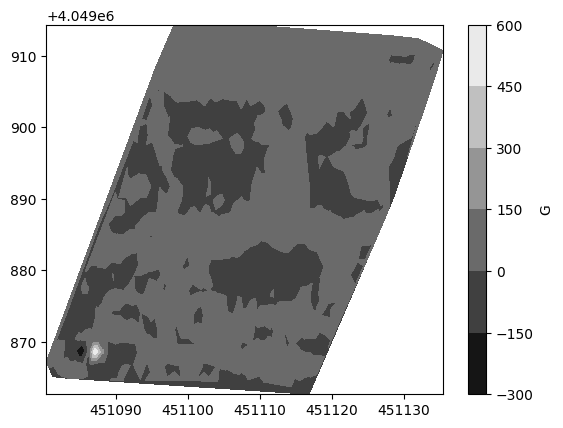

In [ ]:
#Affichage des données brutes
plt.figure()
plt.contourf(X, Y, Z, cmap='gray')
plt.colorbar(label='G')

In [ ]:
#Application de la méthode IQR
def Remove_outliers_IQR(data, i):

  col=data[: , i]
  Q1=np.percentile(col, 25)
  Q3=np.percentile(col, 75)

  IQR=Q3-Q1

  lower_bound=Q1-1.6*IQR
  Upper_bound=Q3+1.6*IQR


  return data[(col>=lower_bound) & (col<=Upper_bound)]

In [ ]:
#Application de la fonction sur nos données
IQR_Data=Remove_outliers_IQR(data, 3)


In [ ]:
#Séparation des colonnes des données traitées
new_x=IQR_Data[: , 0]
new_y=IQR_Data[: , 1]
new_T=IQR_Data[: , 2]
new_G=IQR_Data[: , 3]

In [ ]:
#Création du grid
new_xi=np.linspace(new_x.min(), new_x.max(), 6000)
new_yi=np.linspace(new_y.min(), new_y.max(), 6000)
new_X, new_Y=np.meshgrid(new_xi, new_yi)
new_Z=griddata((new_x, new_y), new_G, (new_X, new_Y), method='linear')


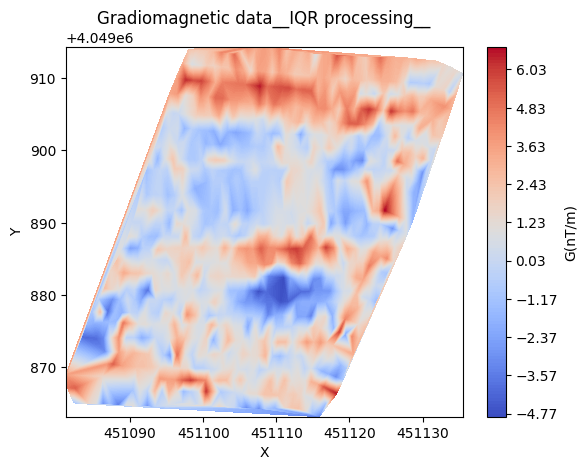

In [ ]:
#Affichagee apres appllcaition IQR
levels=np.arange(new_G.min(), new_G.max(), 0.1)
plt.figure()
plt.contourf(new_X, new_Y, new_Z, cmap='coolwarm', levels=levels)
plt.colorbar(label='G(nT/m)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gradiomagnetic data__IQR processing__')
plt.savefig('../figures/Gradiomagnetic data__IQR processing__.png')

In [ ]:
#__Detection des outliers par Isolation Forest
from sklearn.ensemble import IsolationForest

#Reshape de G pour qu'il soit 2D (requis pour sklearn)
G_reshaped=G.reshape(-1 , 1)

#Initialisation du modèle Isolation Forest
iso=IsolationForest(contamination=0.1, random_state=42)

#Détection des anomalies (-1=donnée anormale, 1=donnée normale)
anomalies=iso.fit_predict(G_reshaped)

#Transforamtion en format binaire (1=anomalie, 0=données normale)
anomalies = np.where(anomalies == -1, 1, 0)

#Indices des données normales
clean_indices=np.where(anomalies==0)[0]

#Filtrage des données
x_cleaned=x[clean_indices]
y_cleaned=y[clean_indices]
T_cleaned=T[clean_indices]
G_cleaned=G[clean_indices]


<ipython-input-31-af648e253a85>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x , y , anomalies, cmap='coolwarm', label='1')


Text(0.5, 1.0, 'Affichage des anomalies')

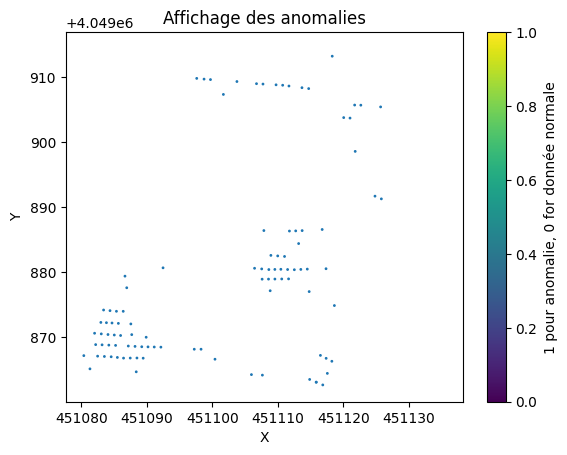

In [ ]:
#Affichage des anomalies
plt.figure()
plt.scatter(x , y , anomalies, cmap='coolwarm', label='1')
plt.colorbar(label='1 pour anomalie, 0 for donnée normale')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Affichage des anomalies')

In [ ]:
#Création du grid
from scipy.interpolate import griddata
xi_cleaned=np.linspace(x_cleaned.min(), x_cleaned.max(), 3000)
yi_cleaned=np.linspace(y_cleaned.min(), y_cleaned.max(), 3000)
X_cleaned, Y_cleaned=np.meshgrid(xi_cleaned, yi_cleaned)
Z_cleaned=griddata((x_cleaned,y_cleaned), G_cleaned, (X_cleaned, Y_cleaned), method='linear')


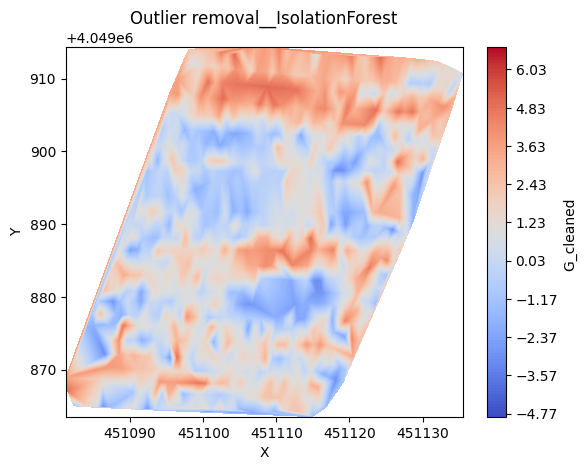

In [ ]:
#Affichage de la carte Gradio après filtrage
plt.figure()
levels=np.arange(new_G.min(), new_G.max(), 0.1)
plt.contourf(X_cleaned, Y_cleaned, Z_cleaned, cmap='coolwarm', levels=levels)
plt.colorbar(label='G_cleaned ')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Outlier removal__IsolationForest')
plt.savefig('../figures/Outlier removal__IsolationForest.png')

In [ ]:
#Chargement de l'image traitée par oasis montaj
from skimage import io
Oasis_Montaj=io.imread('../figures/G_Map.png')


In [ ]:
#Chargement de notre traitement
IQR=io.imread('../figures/Gradiomagnetic data__IQR processing__.png')
Iso_For=io.imread('../figures/Outlier removal__IsolationForest.png')


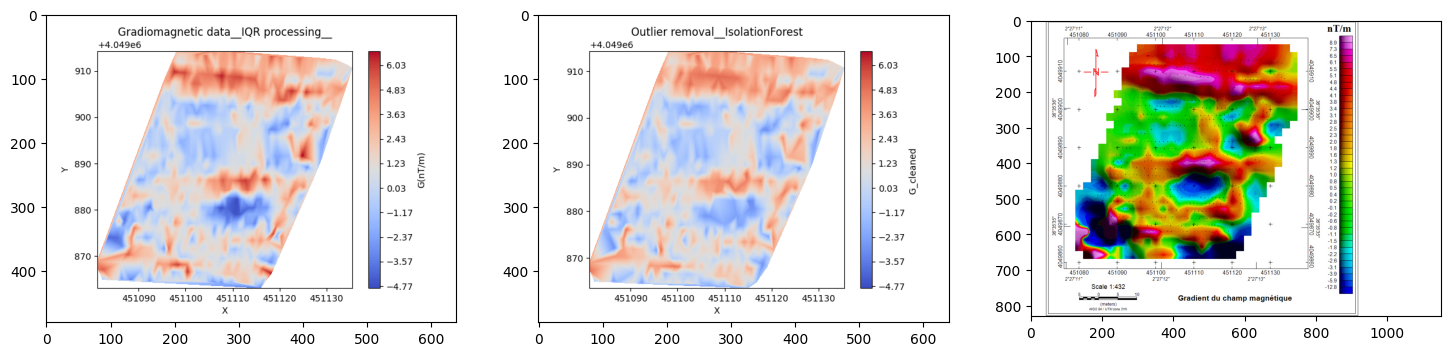

In [ ]:
#Comapraison
plt.figure(figsize=(18,10))
plt.subplot(1 , 3, 1)
plt.imshow(IQR)
plt.subplot(1 , 3 , 2)
plt.imshow(Iso_For)
plt.subplot(1 , 3 , 3)
plt.imshow(Oasis_Montaj)